## Trace Ratio Optimization

We want to solve the following Trace Ratio Optimization (TRO) problem:

$P: \text{max}_X\; \frac{\mathbb{E}[||X^T\mathbf{y}(t)||^2]}{\mathbb{E}[||X^T\mathbf{v}(t)||^2]}$
$\text{s.t. } X^TX=I,$

in a distributed setting using the distributed adaptive signal fusion (DASF) framework.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import networkx as nx
sys.path.append('../dasf_toolbox/')
import rtls_functions as rtls
from dasf_toolbox import dasf
from dasf_toolbox import fdasf
from dasf_toolbox import dasf_block
import pygsp as pg

rng = np.random.default_rng()

The network on which the TRO problem will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node.

In [2]:
# Number of nodes.
nbnodes = 10
# Number of channels per node.
nbsensors_vec = 5 * np.ones(nbnodes)
nbsensors_vec = nbsensors_vec.astype(int)
# Number of channels in total.
nbsensors = np.sum(nbsensors_vec)
# Create adjacency matrix (hollow matrix) of a random graph.
G = pg.graphs.ErdosRenyi(nbnodes, p=0.8, connected=True)
graph_adj = G.W.toarray()

The adjacency matrix of the network is:

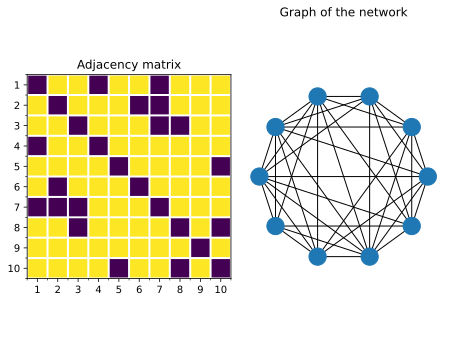

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig, ax = plt.subplots(1, 2)
ax[0].imshow(graph_adj)
ax[0].set_xticks(np.arange(0, nbnodes, 1))
ax[0].set_yticks(np.arange(0, nbnodes, 1))
ax[0].set_xticklabels(np.arange(1, nbnodes + 1, 1))
ax[0].set_yticklabels(np.arange(1, nbnodes + 1, 1))
ax[0].set_xticks(np.arange(-.5, nbnodes, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, nbnodes, 1), minor=True)
ax[0].grid(which='minor', color='w', linestyle='-', linewidth=2)
ax[0].set_title('Adjacency matrix')

graph = nx.from_numpy_array(graph_adj)
nx.draw_circular(graph)
ax[1].set_title('Graph of the network')
ax[1].axis('equal')

plt.tight_layout()
plt.show()


We now create the multi-channel signals $\mathbf{y}$ and $\mathbf{v}$
measured at the nodes, using the following mixture model:
$\mathbf{v}(t)=B\cdot\mathbf{s}(t)+\mathbf{n}(t)$,
$\mathbf{y}(t)=A\cdot\mathbf{d}(t)+\mathbf{v}(t).$

Each node measures blocks of 10000 samples to estimate the correlation matrices.

In [4]:
# Number of samples of the signals.
nbsamples = 10000

# Number of filters of X.
Q = 1

Y, d = rtls.create_data(nbsensors, nbsamples, Q)

The matrices `Y` and `V` contain in their columns time samples of $\mathbf{y}$ and $\mathbf{v}$ respectively:
$Y = [\mathbf{y}(1);\dots;\mathbf{y}(10000)]$ and $V = [\mathbf{v}(1);\dots;\mathbf{v}(10000)]$.

When solving the TRO problem in the DASF setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is `tro_solver` which solves:

$\text{max}_X\; \frac{\mathbb{E}[||X^T\mathbf{y}_1(t)||^2]}{\mathbb{E}[||X^T\mathbf{y}_2(t)||^2]}$
$\text{s.t. } X^T\Gamma_1X=I.$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$,
$\mathbf{y}_2=\mathbf{v}$ and $\Gamma_1=I$.

The data of the problem are stored in the dictionary `data` (see documentation for
more information).

In [5]:
delta = 1
L = np.diag(1 + np.sqrt(0.1) * rng.normal(loc=0, scale=1, size=(nbsensors, )))
Y_list = [Y]
Gamma_list = [np.identity(nbsensors)]
B_list = [L]
Glob_Const_list = [d, delta]

data = {'Y_list': Y_list, 'B_list': B_list,
        'Gamma_list': Gamma_list, 'Glob_Const_list': Glob_Const_list}


In the distributed setting, each node $q$ will solve a parameterized version of the problem $P$
given by:

$\text{max}_{\widetilde{X}_q}\; \frac{\mathbb{E}[||\widetilde{X}_q^TC_q^T\mathbf{y}(t)||^2]}{\mathbb{E}[||\widetilde{X}_q^TC_q^T\mathbf{v}(t)||^2]}$
$\text{s.t. } \widetilde{X}_q^TC_q^TC_q\widetilde{X}_q=I.$

Therefore, in `tro_solver`, we take $\mathbf{y}_1=C_q^T\mathbf{y}$,
$\mathbf{y}_2=C_q^T\mathbf{v}$ and $\Gamma_1=C_q^TC_q$.

The parameters of the problem are stored in the dictionary `prob_params` (see documentation for
more information), where we choose the number of filters $Q$ (i.e., the number of columns of
$X$) to be equal to 5:

In [6]:
prob_params = {'nbnodes': nbnodes, 'nbsensors_vec': nbsensors_vec,
                   'nbsensors': nbsensors, 'Q': Q, 'nbsamples': nbsamples}

The optimal filter $X^*$ is estimated using the centralized solver `tro_solver` taking
as input the data and problem parameters previously defined:

In [7]:
X_star = rtls.rtls_centralized(prob_params, data)
f_star = rtls.rtls_eval(X_star, data) # f(X_star)

In [8]:
X_star_2 = rtls.rtls_solver_2(prob_params, data)

/esat/biomeddata/users/cmusluog/miniconda/envs/DASF_env/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [9]:
np.linalg.norm(X_star-X_star_2)

3.035812371646955e-06

In [10]:
rtls.rtls_eval(X_star, data), rtls.rtls_eval(X_star_2, data)

(array([[0.07313524]]), array([[0.07313528]]))

In [11]:
np.linalg.norm(X_star.T @ L) ** 2, np.linalg.norm(X_star_2.T @ L) ** 2

(1.0000002029433848, 1.0000014594716728)

For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DASF algorithm to be equal to 100.

In [12]:
prob_params['graph_adj'] = graph_adj

update_path = rng.permutation(range(nbnodes))
prob_params['update_path'] = update_path

nbiter = 100
conv = {'nbiter': nbiter}

We also provide $X^*$ to compare the estimation we get from the DASF algorithm to the optimal
value.

In [13]:
prob_params['X_star'] = X_star
prob_params['compare_opt'] = True

Finally, the TRO problem is solved in a distributed setting using the DASF framework:

In [14]:
X_est, norm_diff, norm_err, f_seq = dasf(prob_params, data, rtls.rtls_solver,
                                             conv, prob_select_sol=None, prob_eval=rtls.rtls_eval)

/esat/biomeddata/users/cmusluog/miniconda/envs/DASF_env/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py:375: RuntimeWarning: invalid value encountered in scalar divide
  cauchy_point = -np.dot(g, g) / np.dot(A_g, A_g) * g
/esat/biomeddata/users/cmusluog/miniconda/envs/DASF_env/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py:114: RuntimeWarning: overflow encountered in scalar multiply
  discriminant = b*b - 4*a*c
/esat/biomeddata/users/cmusluog/miniconda/envs/DASF_env/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:144: RuntimeWarning: overflow encountered in scalar multiply
  merit_function = f + penalty*norm(b)
/esat/biomeddata/users/cmusluog/miniconda/envs/DASF_env/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:149: RuntimeWarning: overflow encountered in scalar multiply
  merit_function_next = f_next + penalty*norm(b_next)
/esat/b

ValueError: array must not contain infs or NaNs

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

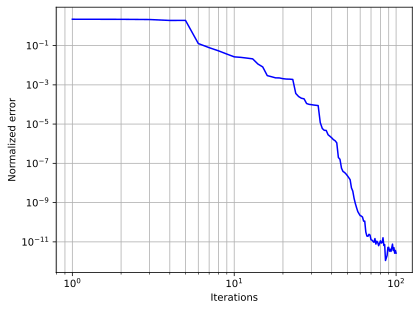

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
plt.show()

Let us now try the alternative, computationally more efficient F-DASF algorithm to solve the TRO problem in a distributed setting, and compare it to the DASF algorithm.

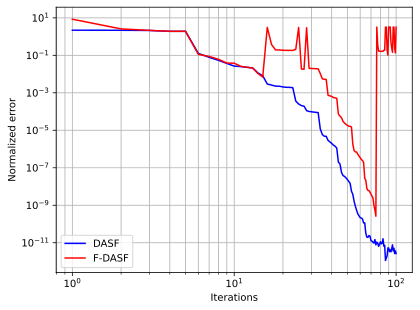

In [ ]:
from dasf_toolbox import fdasf

X_est_fdasf, norm_diff_fdasf, norm_err_fdasf, f_seq_fdasf = fdasf(
        prob_params, data, rtls.rtls_aux_solver, rtls.rtls_eval, conv)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b', label='DASF')
ax.loglog(range(1, nbiter + 1), norm_err_fdasf, color='r', label='F-DASF')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
ax.legend()
plt.show()

This latter simulation experimentally demonstrates that the convergence behaviours of F-DASF and DASF are very similar, while for fractional programs, F-DASF is significantly more efficient computationally. 